In [1]:
import cooler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing as mp
import h5py
import pickle
import seaborn as sns
import tqdm

from scipy import stats

from statsmodels.stats.multitest import multipletests

import sys
import itertools
import time
import datetime

sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')
from __init__ import *
from __init__jupyterlab import * 
import snmcseq_utils

In [2]:
default_colorbar_kws = DEFAULT_COLORBAR_KWS

today = datetime.date.today()
print(today)

2020-11-25


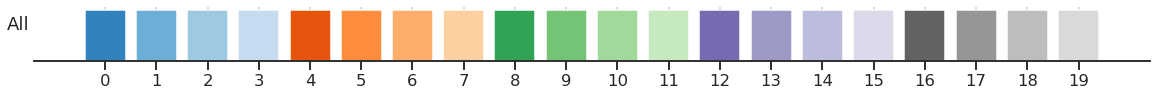

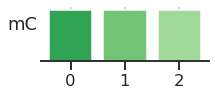

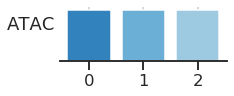

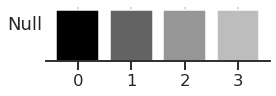

In [3]:
# color palette
cm = plt.cm.tab20c.colors

# settle down on a color palette
colors_mc = [cm[8], cm[9], cm[10],]
colors_atac = [cm[0], cm[1], cm[2],]
colors_null = ['black', cm[16], cm[17], cm[18],]

color_tracks = [
    cm,
    colors_mc,
    colors_atac,
    colors_null,
]

labels = [
    'All',
    'mC',
    'ATAC',
    'Null',
]

for color_track, label in zip(color_tracks, labels):
    n = len(color_track)
    fig, ax = plt.subplots(figsize=(1*n,1))
    ax.bar(np.arange(n), 1, 
           color=color_track)
    ax.set_xticks(np.arange(n))
    ax.set_ylabel(label, rotation=0, ha='right')
    sns.despine(ax=ax, left=True)
    ax.set_yticks([])
    plt.show()

In [4]:
mod_palette = {
    'mc': 'C2',
    'atac': 'C0',
    'null': 'k',
}

mod_palette_comp = {
    'mc': colors_mc,
    'atac': colors_atac,
    'null': colors_null,
}


KB = 1000
def p25(x):
    return np.percentile(x, 25)
def p75(x):
    return np.percentile(x, 75)


In [5]:
def kth_diag_indices(n, k=0):
    """
    """
    assert k >= 0
    
    row_idx = np.arange(n)
    col_idx = np.arange(n)
    
    col_idx = row_idx + k
    
    if k > 0:
        return row_idx[:-k], col_idx[:-k]
    if k == 0:
        return row_idx, col_idx

def mat_values_kth_diag_indices(mat, k=0):
    """
    """
    return mat[kth_diag_indices(len(mat), k=k)]

In [6]:
def enh_gene_id_to_binidx(_table, tsss, enhs, resolution):
    """
    Given a dataframe of enh-gene pairs (by IDs)
    return which bins in HiC data they correspond to
    
    Return a dataframe with dist_bin as index, 'gene_bin', 'enh_bin' as columns
    """
    # merge gid, enh_id with genome locations
    _tmp = pd.merge(_table, tsss.rename(columns={'chr': 'gene_chr',
                                                 'start': 'gene_start',
                                                 'end': 'gene_end',
                                                 'gid': 'gene',
                                                }), on='gene')

    _tmp = pd.merge(_tmp, enhs.rename(columns={'chr': 'enh_chr',
                                               'start': 'enh_start',
                                               'end': 'enh_end',
                                               'center': 'enh_center',
                                               'enh_id': 'enh',
                                              }), on='enh')
    # find the correct bins
    _tmp['enh_bin'] = (_tmp['enh_center'].values/resolution).astype(int)
    _tmp['gene_bin'] = (_tmp['gene_start'].values/resolution).astype(int)
    _tmp['dist_bin'] = np.abs(_tmp['enh_bin'] - _tmp['gene_bin'])
    _tmp = _tmp.set_index('dist_bin')
    
    return _tmp

In [7]:
def get_contact_stats(mat, paired_bin_tables, resolution, distance_cutoff=1e6):
    """
    """
    distance_idx = np.arange(1, int(distance_cutoff/resolution))
    distances = distance_idx * resolution

    contacts_mean = []
    contacts_std = []
    contacts_sig_pairs_mean = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})
    contacts_sig_pairs_std = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})

    for i in tqdm.tqdm(distance_idx):
        contacts = mat_values_kth_diag_indices(mat, k=i)
        contacts_mean.append(np.nanmean(contacts)) 
        contacts_std.append(np.nanstd(contacts)) 

        for _label, _table in paired_bin_tables.items():
            try:
                pairs = _table.loc[i]
                contacts_sig_pairs = mat[(pairs['enh_bin'].values, pairs['gene_bin'].values)]
            except:
                contacts_sig_pairs = []

            contacts_sig_pairs_mean[_label].append(np.nanmean(contacts_sig_pairs)) 
            contacts_sig_pairs_std[_label].append(np.nanstd(contacts_sig_pairs)) 

    contacts_mean = np.array(contacts_mean)
    contacts_std = np.array(contacts_std)

    contacts_sig_pairs_mean = collections.OrderedDict({
                    _label: np.array(_table) for _label, _table in contacts_sig_pairs_mean.items()})
    contacts_sig_pairs_std = collections.OrderedDict({
                    _label: np.array(_table) for _label, _table in contacts_sig_pairs_std.items()})

    return (contacts_mean, contacts_std, 
            contacts_sig_pairs_mean, contacts_sig_pairs_std,
           )

def get_contacts(mat, paired_bin_tables, resolution, distance_idx):
    """
    given distances/distance idx; 
    - contacts: a list of numpy arrays
    - contacts_sig_pairs: a dict of list of numpy arrays 
    """

    contacts = []
    contacts_sig_pairs = collections.OrderedDict({_label: [] for _label, _table in paired_bin_tables.items()})

    for i in tqdm.tqdm(distance_idx):
        _contacts = mat_values_kth_diag_indices(mat, k=i)
        contacts.append(_contacts) 

        for _label, _table in paired_bin_tables.items():
            try:
                pairs = _table.loc[i]
                _contacts_sig_pairs = mat[(pairs['enh_bin'].values, pairs['gene_bin'].values)]
            except:
                _contacts_sig_pairs = []
            contacts_sig_pairs[_label].append(_contacts_sig_pairs) 

    return (contacts, contacts_sig_pairs)

In [8]:
def plot_contact_stats(
    chromosome, celltype, resolution,
    distances, contacts_mean, contacts_std, 
    contacts_sig_pairs_mean, contacts_sig_pairs_std, 
    track_names, colors,
    output_fig,
    ):
    """
    """
    
    fig, axs = plt.subplots(2, 4, figsize=(5*4,5*2), sharey=True, sharex=True)

    # all together
    ax = axs[0,0]
    _x, _y, _yerr = distances, contacts_mean, contacts_std
    color='gray'
    ax.plot(_x, _y, '-', color=color, linewidth=3, label='all_bins')
    for i, (_name, _color) in enumerate(zip(track_names, colors)):
        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.plot(_x, _y, '-', color=_color, linewidth=3, label=_name)
        
    ax.xaxis.set_major_formatter(mtick.EngFormatter())
    ax.set_yscale('log')
    ax.set_xlabel('Genomic distance')
    ax.set_xlim([0, 1e5])
    ax.set_ylim([1e-3, 1e-1])
    ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')
    ax.set_title("{} {}, {} HiC resolution".format(chromosome, celltype, resolution))

    for ax in axs[0,1:]:
        ax.axis('off')

    # specific plots
    for i, (ax, _name, _color) in enumerate(zip(axs[1], track_names, colors)):
        _x, _y, _yerr = distances, contacts_mean, contacts_std
        color='gray'
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=color, alpha=0.2)
        ax.plot(_x, _y, '-', color=color, linewidth=5, label='all_bins', alpha=1)

        _x, _y, _yerr = distances, contacts_sig_pairs_mean[_name], contacts_sig_pairs_std[_name]
        ax.fill_between(_x, _y-_yerr, _y+_yerr, color=_color, alpha=0.2)
        ax.plot(_x, _y, '-', color=_color, linewidth=5, label=_name, alpha=1)

        ax.xaxis.set_major_formatter(mtick.EngFormatter())
        ax.set_yscale('log')
        ax.set_xlabel('Genomic distance')
        ax.set_xlim([0, 1e5])
        ax.set_ylim([1e-3, 1e-1])

        if i == 0:
            ax.set_ylabel('Contact frequency\n(normalized mean +/- std)')

    # legends
    handles, labels = snmcseq_utils.combine_legends(axs.flat)
    handles, labels = snmcseq_utils.dedup_legends(handles, labels)
    axs[0,1].legend(handles, labels, bbox_to_anchor=(1,1), loc='upper left')
    
    snmcseq_utils.savefig(fig, output_fig)
#     plt.show()
    
    plt.close()
    return 

In [9]:
chromosomes = ['chr'+str(i+1) for i in range(22)] + ['chrX']
celltypes = ['L2_3', 'L4', 'L5', 'L6', 
             'Pvalb', 'Sst', 'Vip', 'Ndnf']
resolutions = [
#     1000, 
#     2000, # memory problems
    5000, 
    10000, 
    20000, # not useful 
#     50000, 
#     100000, # 100kb 
]

celltype = 'L2_3'
resolution = 10000
chromosome = 'chr1'

# Apply this to different HiC map 

- resolutions - 10kb, 
- chromosomes - combine
- cell types

Todo: 
- make sure the enhancer indices are correct 
- make sure the HiC map indices are correct

In [10]:
# enhancers lifted
f = './hic_from_ethan/enhancers_lifted.bed'
enh_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'enh_id'])
enh_list['center'] = (enh_list['start'] + enh_list['end'])/2
print(enh_list.shape)
enh_list.head()

# tss lifted
f = './hic_from_ethan/tss_lifted.bed'
tss_list = pd.read_csv(f, sep='\t', header=None, names=['chr', 'start', 'end', 'gid'])
print(tss_list.shape)
tss_list.head()

# enh - tss linked list

# orig significant pairs (enh_index and gid)

# load some results
f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_mc.tsv'
linked_pairs_mc = pd.read_csv(f, sep="\t")
print(linked_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_linked_pairs_atac.tsv'
linked_pairs_atac = pd.read_csv(f, sep="\t")
print(linked_pairs_atac.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_mc.tsv'
correlated_pairs_mc = pd.read_csv(f, sep="\t")
print(correlated_pairs_mc.shape)

f = '/sphere/fangming/enhancers/scripts/results_new/fig2_201027_correlated_pairs_atac.tsv'
correlated_pairs_atac = pd.read_csv(f, sep="\t")
print(correlated_pairs_atac.shape)

linked_pairs_mc.head()

(126134, 5)
(33814, 4)
(7455, 3)
(3879, 3)
(85596, 3)
(50012, 3)


,gene,enh,dist
0,ENSMUSG00000000058,181997,14555
1,ENSMUSG00000000088,221978,48225
2,ENSMUSG00000000126,35942,90017
3,ENSMUSG00000000126,35953,4552
4,ENSMUSG00000000126,35954,5567


In [11]:
# celltype = 'L2_3' 

# distances
distance_cutoff = 1e5
distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
distances = distance_idx * resolution

for celltype in celltypes:
    print(celltype)
    
    contacts = [[] for i in np.arange(len(distances))]
    contacts_sig_pairs = collections.OrderedDict({
            'linked_mc': [[] for i in np.arange(len(distances))],
            'linked_atac': [[] for i in np.arange(len(distances))],
            'correlated_mc': [[] for i in np.arange(len(distances))],
            'correlated_atac': [[] for i in np.arange(len(distances))],
        })

    for chromosome in chromosomes:
        print(celltype, resolution, chromosome)

        # read in the matrix 
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]

        # get paired bins
        paired_bin_tables = collections.OrderedDict({
            'linked_mc': enh_gene_id_to_binidx(linked_pairs_mc, tsss, enhs, resolution),
            'linked_atac': enh_gene_id_to_binidx(linked_pairs_atac, tsss, enhs, resolution),
            'correlated_mc': enh_gene_id_to_binidx(correlated_pairs_mc, tsss, enhs, resolution),
            'correlated_atac': enh_gene_id_to_binidx(correlated_pairs_atac, tsss, enhs, resolution),
        })
        track_names = list(paired_bin_tables.keys())
        colors = [
            mod_palette_comp['mc'][0],
            mod_palette_comp['atac'][0],
            mod_palette_comp['mc'][2],
            mod_palette_comp['atac'][2],
        ]

        # contact stats
        (_contacts, _contacts_sig_pairs
        ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)

        # combine all chromosomes 
        for idx, dist in enumerate(distances):
            contacts[idx] += list(_contacts[idx])
            for key in _contacts_sig_pairs.keys():
                contacts_sig_pairs[key][idx] += list(_contacts_sig_pairs[key][idx])

    # stats
    contacts_mean = np.array([np.nanmean(val) for val in contacts])
    contacts_std = np.array([np.nanstd(val) for val in contacts])
    contacts_n = np.array([len(val) for val in contacts])

    contacts_sig_pairs_mean = collections.OrderedDict({
        key: np.zeros(len(distances)) 
        for key in contacts_sig_pairs.keys()
    })
    contacts_sig_pairs_std = contacts_sig_pairs_mean.copy()
    contacts_sig_pairs_n = contacts_sig_pairs_mean.copy()

    for key in contacts_sig_pairs.keys():
        contacts_sig_pairs_mean[key] = np.array([np.nanmean(val) 
                                                 for val in contacts_sig_pairs[key]])

        contacts_sig_pairs_std[key] = np.array([np.nanstd(val) 
                                                for val in contacts_sig_pairs[key]])
        
        contacts_sig_pairs_n[key] = np.array([len(val) 
                                              for val in contacts_sig_pairs[key]])

    
    # run and save results
    output_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_{}_{}_{}.pkl'.format(celltype, resolution, today)
                 )

    output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
                  'hic_contact_enrichment_{}_{}_{}.pdf'.format(celltype, resolution, today)
                 )
    # save results
    # distances, contacts_mean, contacts_std ## these are numpy arrays 
    # contacts_sig_pairs_mean, contacts_sig_pairs_std ## these
    with open(output_res, 'wb') as fwh:
        pickle.dump((distances, 
                     contacts_mean, contacts_std, contacts_n,
                     contacts_sig_pairs_mean, 
                     contacts_sig_pairs_std,
                     contacts_sig_pairs_n,
                    ), fwh)

    # plot
    plot_contact_stats(
        'all_chroms', celltype, resolution,
        distances, contacts_mean, contacts_std, 
        contacts_sig_pairs_mean, contacts_sig_pairs_std, 
        track_names, colors,
        output_fig,
        )

    

L2_3
L2_3 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 151.61it/s]


L2_3 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 335.36it/s]


L2_3 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 248.11it/s]


L2_3 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 389.46it/s]


L2_3 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 387.91it/s]


L2_3 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 418.43it/s]


L2_3 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 405.08it/s]


L2_3 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 379.19it/s]


L2_3 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 444.12it/s]


L2_3 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 447.75it/s]


L2_3 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 405.67it/s]


L2_3 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 416.84it/s]


L2_3 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 524.97it/s]


L2_3 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 463.60it/s]


L2_3 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 475.82it/s]


L2_3 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 505.30it/s]


L2_3 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 463.13it/s]


L2_3 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 503.28it/s]


L2_3 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 595.47it/s]


L2_3 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 497.23it/s]


L2_3 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 650.25it/s]


L2_3 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 546.60it/s]


L2_3 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 574.29it/s]


L4
L4 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 314.04it/s]


L4 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 324.01it/s]


L4 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 386.79it/s]


L4 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 379.89it/s]


L4 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 388.25it/s]


L4 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 188.59it/s]


L4 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 417.31it/s]


L4 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 414.96it/s]


L4 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 280.42it/s]


L4 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 451.69it/s]


L4 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 416.68it/s]


L4 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 160.37it/s]


L4 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 380.39it/s]


L4 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 462.49it/s]


L4 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 420.19it/s]


L4 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 491.34it/s]


L4 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 479.12it/s]


L4 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 500.94it/s]


L4 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 559.64it/s]


L4 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 511.91it/s]


L4 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 663.46it/s]


L4 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 289.38it/s]


L4 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 563.09it/s]


L5
L5 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 284.02it/s]


L5 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 165.34it/s]


L5 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 357.22it/s]


L5 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 392.01it/s]


L5 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 390.21it/s]


L5 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 406.81it/s]


L5 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 417.17it/s]


L5 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 429.27it/s]


L5 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 440.57it/s]


L5 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 437.13it/s]


L5 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 403.09it/s]


L5 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 431.11it/s]


L5 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 523.83it/s]


L5 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 466.63it/s]


L5 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 450.78it/s]


L5 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 505.72it/s]


L5 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 460.47it/s]


L5 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 498.05it/s]


L5 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 582.93it/s]


L5 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 516.19it/s]


L5 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 668.38it/s]


L5 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 538.08it/s]


L5 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 339.50it/s]


L6
L6 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 322.71it/s]


L6 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 184.91it/s]


L6 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 249.85it/s]


L6 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 391.64it/s]


L6 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 383.18it/s]


L6 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 407.23it/s]


L6 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 433.30it/s]


L6 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 429.44it/s]


L6 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 420.06it/s]


L6 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 450.78it/s]


L6 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 375.69it/s]


L6 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 426.18it/s]


L6 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 520.17it/s]


L6 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 466.28it/s]


L6 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 478.71it/s]


L6 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 502.26it/s]


L6 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 468.26it/s]


L6 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 490.98it/s]


L6 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 592.25it/s]


L6 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 499.08it/s]


L6 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 650.70it/s]


L6 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 547.44it/s]


L6 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 553.81it/s]


Pvalb
Pvalb 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 211.76it/s]


Pvalb 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 301.66it/s]


Pvalb 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 380.94it/s]


Pvalb 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 237.42it/s]


Pvalb 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 386.49it/s]


Pvalb 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 416.73it/s]


Pvalb 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 400.76it/s]


Pvalb 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 383.42it/s]


Pvalb 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 407.81it/s]


Pvalb 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 436.29it/s]


Pvalb 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 416.34it/s]


Pvalb 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 427.75it/s]


Pvalb 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 504.81it/s]


Pvalb 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 460.08it/s]


Pvalb 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 475.09it/s]


Pvalb 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 485.77it/s]


Pvalb 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 461.42it/s]


Pvalb 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 526.72it/s]


Pvalb 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 251.03it/s]


Pvalb 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 500.48it/s]


Pvalb 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 686.70it/s]


Pvalb 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 534.63it/s]


Pvalb 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 552.25it/s]


Sst
Sst 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 308.91it/s]


Sst 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 347.15it/s]


Sst 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 353.80it/s]


Sst 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 381.27it/s]


Sst 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 399.23it/s]


Sst 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 389.56it/s]


Sst 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 405.73it/s]


Sst 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 424.70it/s]


Sst 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 398.18it/s]


Sst 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 447.35it/s]


Sst 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 412.24it/s]


Sst 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 416.01it/s]


Sst 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 524.91it/s]


Sst 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 467.70it/s]


Sst 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 486.27it/s]


Sst 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 490.94it/s]


Sst 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 467.35it/s]


Sst 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 509.39it/s]


Sst 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 577.74it/s]


Sst 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 518.90it/s]


Sst 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 657.82it/s]


Sst 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 518.40it/s]


Sst 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 571.86it/s]


Vip
Vip 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 311.78it/s]


Vip 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 170.65it/s]


Vip 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 244.18it/s]


Vip 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 384.21it/s]


Vip 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 402.58it/s]


Vip 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 392.25it/s]


Vip 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 401.81it/s]


Vip 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 399.26it/s]


Vip 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 421.46it/s]


Vip 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 446.71it/s]


Vip 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 424.50it/s]


Vip 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 413.85it/s]


Vip 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 501.85it/s]


Vip 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 478.29it/s]


Vip 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 412.01it/s]


Vip 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 498.88it/s]


Vip 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 464.73it/s]


Vip 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 506.09it/s]


Vip 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 591.22it/s]


Vip 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 497.26it/s]


Vip 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 512.19it/s]


Vip 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 527.23it/s]


Vip 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 544.93it/s]


Ndnf
Ndnf 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 300.46it/s]


Ndnf 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 337.58it/s]


Ndnf 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 342.08it/s]


Ndnf 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 386.47it/s]


Ndnf 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 388.20it/s]


Ndnf 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 403.70it/s]


Ndnf 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 407.88it/s]


Ndnf 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 416.56it/s]


Ndnf 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 430.35it/s]


Ndnf 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 448.13it/s]


Ndnf 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 410.63it/s]


Ndnf 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 188.04it/s]


Ndnf 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 519.71it/s]


Ndnf 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 467.68it/s]


Ndnf 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 457.70it/s]


Ndnf 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 502.82it/s]


Ndnf 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 478.45it/s]


Ndnf 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 505.92it/s]


Ndnf 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 545.82it/s]


Ndnf 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 509.52it/s]


Ndnf 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 662.77it/s]


Ndnf 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 530.73it/s]


Ndnf 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 571.59it/s]


# use only cell type-specific pairs

In [12]:
# gene expression profiles
f = '/sphere/fangming/enhancers/scripts/data_organized/gene_rna_clsts.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [13]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}
def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)

clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [14]:
# merge RNA profiles
_tmp = gene_rna_clsts.T
_tmp['annot'] = clst_annot_broad.loc[_tmp.index]
gene_rna_clsts_broad = _tmp.groupby('annot').median().T
gene_rna_clsts_broad_rank = gene_rna_clsts_broad.rank(pct=True, axis=1)
print(gene_rna_clsts_broad_rank.shape)
gene_rna_clsts_broad_rank.head()

(12095, 8)


annot,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
ENSMUSG00000000001,0.500,0.750,0.250,0.625,0.875,0.125,0.375,1.000
ENSMUSG00000000056,0.125,0.750,0.875,0.500,0.625,1.000,0.250,0.375
ENSMUSG00000000058,0.625,1.000,0.250,0.375,0.750,0.125,0.500,0.875
ENSMUSG00000000078,0.250,1.000,0.625,0.750,0.125,0.500,0.875,0.375
ENSMUSG00000000085,0.250,0.125,0.625,0.375,0.875,0.500,0.750,1.000


In [15]:
# celltype = 'L2_3' 

# distances
distance_cutoff = 1e5
distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
distances = distance_idx * resolution

for celltype in celltypes:
    print(celltype)
    
    contacts = [[] for i in np.arange(len(distances))]
    contacts_sig_pairs = collections.OrderedDict({
            'linked_mc': [[] for i in np.arange(len(distances))],
            'linked_atac': [[] for i in np.arange(len(distances))],
            'correlated_mc': [[] for i in np.arange(len(distances))],
            'correlated_atac': [[] for i in np.arange(len(distances))],
        })

    for chromosome in chromosomes:
        print(celltype, resolution, chromosome)

        # read in the matrix 
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        # all enhancers and tss on that chromosomes
        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]
        
        # only include the gene if it is actively expressed (>50% across cell types)
        active_genes = gene_rna_clsts_broad_rank[gene_rna_clsts_broad_rank[celltype]>0.5].index.values
        tsss = tsss[tsss['gid'].isin(active_genes)]
        
        # get paired bins
        paired_bin_tables = collections.OrderedDict({
            'linked_mc': enh_gene_id_to_binidx(linked_pairs_mc, tsss, enhs, resolution),
            'linked_atac': enh_gene_id_to_binidx(linked_pairs_atac, tsss, enhs, resolution),
            'correlated_mc': enh_gene_id_to_binidx(correlated_pairs_mc, tsss, enhs, resolution),
            'correlated_atac': enh_gene_id_to_binidx(correlated_pairs_atac, tsss, enhs, resolution),
        })
        track_names = list(paired_bin_tables.keys())
        colors = [
            mod_palette_comp['mc'][0],
            mod_palette_comp['atac'][0],
            mod_palette_comp['mc'][2],
            mod_palette_comp['atac'][2],
        ]

        # contact stats
        (_contacts, _contacts_sig_pairs
        ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)

        # combine all chromosomes 
        for idx, dist in enumerate(distances):
            contacts[idx] += list(_contacts[idx])
            for key in _contacts_sig_pairs.keys():
                contacts_sig_pairs[key][idx] += list(_contacts_sig_pairs[key][idx])

    # stats
    contacts_mean = np.array([np.nanmean(val) for val in contacts])
    contacts_std = np.array([np.nanstd(val) for val in contacts])
    contacts_n = np.array([len(val) for val in contacts])

    contacts_sig_pairs_mean = collections.OrderedDict({
        key: np.zeros(len(distances)) 
        for key in contacts_sig_pairs.keys()
    })
    contacts_sig_pairs_std = contacts_sig_pairs_mean.copy()
    contacts_sig_pairs_n = contacts_sig_pairs_mean.copy()

    for key in contacts_sig_pairs.keys():
        contacts_sig_pairs_mean[key] = np.array([np.nanmean(val) 
                                                 for val in contacts_sig_pairs[key]])

        contacts_sig_pairs_std[key] = np.array([np.nanstd(val) 
                                                for val in contacts_sig_pairs[key]])
        
        contacts_sig_pairs_n[key] = np.array([len(val) 
                                              for val in contacts_sig_pairs[key]])

    
    # run and save results
    output_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec_{}_{}_{}.pkl'.format(celltype, resolution, today)
                 )

    output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
                  'hic_contact_enrichment_celltypespec_{}_{}_{}.pdf'.format(celltype, resolution, today)
                 )
    # save results
    # distances, contacts_mean, contacts_std ## these are numpy arrays 
    # contacts_sig_pairs_mean, contacts_sig_pairs_std ## these
    with open(output_res, 'wb') as fwh:
        pickle.dump((distances, 
                     contacts_mean, contacts_std, contacts_n,
                     contacts_sig_pairs_mean, 
                     contacts_sig_pairs_std,
                     contacts_sig_pairs_n,
                    ), fwh)

    # plot
    plot_contact_stats(
        'all_chroms', celltype, resolution,
        distances, contacts_mean, contacts_std, 
        contacts_sig_pairs_mean, contacts_sig_pairs_std, 
        track_names, colors,
        output_fig,
        )

    

L2_3
L2_3 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 348.97it/s]


L2_3 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 334.36it/s]


L2_3 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 401.93it/s]


L2_3 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 422.84it/s]


L2_3 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 419.10it/s]


L2_3 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 460.56it/s]


L2_3 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 450.83it/s]


L2_3 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 361.38it/s]


L2_3 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 493.52it/s]


L2_3 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 484.97it/s]


L2_3 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 358.01it/s]


L2_3 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 408.54it/s]


L2_3 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 557.38it/s]


L2_3 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 513.13it/s]


L2_3 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 522.43it/s]


L2_3 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 584.11it/s]


L2_3 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 493.34it/s]


L2_3 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 218.92it/s]


L2_3 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 702.63it/s]


L2_3 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 539.88it/s]


L2_3 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 905.86it/s]


L2_3 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 562.28it/s]


L2_3 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 628.21it/s]


L4
L4 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 46.13it/s]


L4 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 259.84it/s]


L4 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 378.47it/s]


L4 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 350.71it/s]


L4 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 260.08it/s]


L4 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 387.82it/s]


L4 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 451.33it/s]


L4 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 449.98it/s]


L4 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 508.80it/s]


L4 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 479.95it/s]


L4 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 417.78it/s]


L4 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 453.02it/s]


L4 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 558.07it/s]


L4 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 536.23it/s]


L4 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 488.77it/s]


L4 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 539.16it/s]


L4 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 548.96it/s]


L4 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 521.13it/s]


L4 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 611.87it/s]


L4 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 555.36it/s]


L4 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 804.48it/s]


L4 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 600.64it/s]


L4 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 656.90it/s]


L5
L5 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 368.32it/s]


L5 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 162.32it/s]


L5 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 387.43it/s]


L5 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 424.89it/s]


L5 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 191.42it/s]


L5 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 438.76it/s]


L5 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 469.77it/s]


L5 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 478.16it/s]


L5 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 462.94it/s]


L5 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 485.80it/s]


L5 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 469.08it/s]


L5 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 455.68it/s]


L5 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 593.51it/s]


L5 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 486.47it/s]


L5 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 500.93it/s]


L5 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 532.81it/s]


L5 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 509.15it/s]


L5 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 656.39it/s]


L5 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 808.06it/s]


L5 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 601.77it/s]


L5 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 815.55it/s]


L5 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 659.54it/s]


L5 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 686.54it/s]


L6
L6 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 361.98it/s]


L6 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 397.51it/s]


L6 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 223.98it/s]


L6 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 395.59it/s]


L6 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 431.44it/s]


L6 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 257.04it/s]


L6 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 480.45it/s]


L6 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 448.03it/s]


L6 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 470.03it/s]


L6 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 488.75it/s]


L6 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 453.39it/s]


L6 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 448.68it/s]


L6 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 608.13it/s]


L6 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 514.58it/s]


L6 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 223.22it/s]


L6 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 574.18it/s]


L6 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 528.64it/s]


L6 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 645.47it/s]


L6 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 642.33it/s]


L6 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 605.96it/s]


L6 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 840.21it/s]


L6 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 553.07it/s]


L6 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 654.52it/s]


Pvalb
Pvalb 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 218.15it/s]


Pvalb 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 368.21it/s]


Pvalb 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 368.90it/s]


Pvalb 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 263.83it/s]


Pvalb 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 426.82it/s]


Pvalb 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 451.27it/s]


Pvalb 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 452.26it/s]


Pvalb 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 438.91it/s]


Pvalb 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 432.31it/s]


Pvalb 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 442.01it/s]


Pvalb 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 451.37it/s]


Pvalb 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 448.08it/s]


Pvalb 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 570.44it/s]


Pvalb 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 527.05it/s]


Pvalb 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 510.65it/s]


Pvalb 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 231.80it/s]


Pvalb 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 506.50it/s]


Pvalb 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 557.94it/s]


Pvalb 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 678.02it/s]


Pvalb 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 528.77it/s]


Pvalb 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 736.15it/s]


Pvalb 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 611.70it/s]


Pvalb 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 600.73it/s]


Sst
Sst 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 366.42it/s]


Sst 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 375.56it/s]


Sst 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 383.28it/s]


Sst 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 424.22it/s]


Sst 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 429.26it/s]


Sst 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 210.00it/s]


Sst 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 451.08it/s]


Sst 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 489.86it/s]


Sst 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 476.33it/s]


Sst 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 465.00it/s]


Sst 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 384.35it/s]


Sst 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 472.89it/s]


Sst 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 520.64it/s]


Sst 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 488.68it/s]


Sst 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 435.82it/s]


Sst 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 528.66it/s]


Sst 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 534.26it/s]


Sst 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 565.53it/s]


Sst 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 724.35it/s]


Sst 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 533.01it/s]


Sst 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 726.01it/s]


Sst 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 647.62it/s]


Sst 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 598.67it/s]


Vip
Vip 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 369.36it/s]


Vip 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 372.77it/s]


Vip 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 397.58it/s]


Vip 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 410.46it/s]


Vip 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 428.87it/s]


Vip 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 440.50it/s]


Vip 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 310.11it/s]


Vip 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 480.27it/s]


Vip 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 470.13it/s]


Vip 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 473.13it/s]


Vip 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 422.48it/s]


Vip 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 447.47it/s]


Vip 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 551.58it/s]


Vip 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 543.30it/s]


Vip 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 479.07it/s]


Vip 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 531.31it/s]


Vip 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 507.72it/s]


Vip 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 596.72it/s]


Vip 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 598.64it/s]


Vip 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 539.61it/s]


Vip 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 734.34it/s]


Vip 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 639.11it/s]


Vip 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 280.23it/s]


Ndnf
Ndnf 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 372.26it/s]


Ndnf 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 386.96it/s]


Ndnf 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 402.61it/s]


Ndnf 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 437.13it/s]


Ndnf 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 416.54it/s]


Ndnf 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 266.58it/s]


Ndnf 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 466.01it/s]


Ndnf 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 217.12it/s]


Ndnf 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 464.57it/s]


Ndnf 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 419.51it/s]


Ndnf 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 435.72it/s]


Ndnf 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 209.23it/s]


Ndnf 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 587.05it/s]


Ndnf 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 498.89it/s]


Ndnf 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 511.39it/s]


Ndnf 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 525.83it/s]


Ndnf 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 500.70it/s]


Ndnf 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 566.73it/s]


Ndnf 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 594.26it/s]


Ndnf 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 407.71it/s]


Ndnf 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 785.79it/s]


Ndnf 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 616.03it/s]


Ndnf 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 622.12it/s]


# analysis group3 -- use only cell type-specific pairs

In [16]:
# gene expression profiles
f = '/sphere/fangming/enhancers/scripts/data_organized/gene_rna_clsts.tsv'
gene_rna_clsts = pd.read_csv(f, sep='\t', index_col=0) #header=True, index=True)
print(gene_rna_clsts.shape)
gene_rna_clsts.head()

# cluster annotation
f = '/cndd2/fangming/projects/scf_enhancers/enhancer_ethan38_200520/ref/annotations_order.tsv'
clst_annot = pd.read_csv(f, sep='\t').set_index('cluster')['annotation']
print(clst_annot.shape)
clst_annot.head()

(12095, 38)
(38,)


cluster
1-1-1       L4/5 IT (1)
1-2-1       L4/5 IT (2)
1-2-2       L4/5 IT (3)
2-1-1    L6 CT Cpa6 (1)
2-1-2    L6 CT Cpa6 (2)
Name: annotation, dtype: object

In [17]:
# merge cluster name
annot_rename_lookup = {
    'L2/3': "L2_3",
    'L4/5': "L4",
    'L6b': "L6",
    'Sncg': "Ndnf",
    'Lamp5': "Ndnf",
}
def rename_annot(x, annot_rename_lookup):
    """
    """
    if x in annot_rename_lookup.keys():
        return annot_rename_lookup[x]
    else:
        return x
    
clst_annot_broad = pd.Series([annot.split(' ')[0] for annot in clst_annot.values], 
                             index=clst_annot.index)

clst_annot_broad = clst_annot_broad.apply(lambda x: rename_annot(x, annot_rename_lookup))

print(clst_annot_broad.shape, 
      len(np.unique(clst_annot_broad.values)),
      np.unique(clst_annot_broad.values),
     )

(38,) 8 ['L2_3' 'L4' 'L5' 'L6' 'Ndnf' 'Pvalb' 'Sst' 'Vip']


In [18]:
# merge RNA profiles
_tmp = gene_rna_clsts.T
_tmp['annot'] = clst_annot_broad.loc[_tmp.index]
gene_rna_clsts_broad = _tmp.groupby('annot').median().T
gene_rna_clsts_broad_rank = gene_rna_clsts_broad.rank(pct=True, axis=1)
print(gene_rna_clsts_broad_rank.shape)
gene_rna_clsts_broad_rank.head()

(12095, 8)


annot,L2_3,L4,L5,L6,Ndnf,Pvalb,Sst,Vip
ENSMUSG00000000001,0.500,0.750,0.250,0.625,0.875,0.125,0.375,1.000
ENSMUSG00000000056,0.125,0.750,0.875,0.500,0.625,1.000,0.250,0.375
ENSMUSG00000000058,0.625,1.000,0.250,0.375,0.750,0.125,0.500,0.875
ENSMUSG00000000078,0.250,1.000,0.625,0.750,0.125,0.500,0.875,0.375
ENSMUSG00000000085,0.250,0.125,0.625,0.375,0.875,0.500,0.750,1.000


In [19]:
# celltype = 'L2_3' 

active_th = 0.75
# distances
distance_cutoff = 1e5
distance_idx = np.arange(1, int(distance_cutoff/resolution)+1)
distances = distance_idx * resolution

for celltype in celltypes:
    print(celltype)
    
    contacts = [[] for i in np.arange(len(distances))]
    contacts_sig_pairs = collections.OrderedDict({
            'linked_mc': [[] for i in np.arange(len(distances))],
            'linked_atac': [[] for i in np.arange(len(distances))],
            'correlated_mc': [[] for i in np.arange(len(distances))],
            'correlated_atac': [[] for i in np.arange(len(distances))],
        })

    for chromosome in chromosomes:
        print(celltype, resolution, chromosome)

        # read in the matrix 
        resource_string = (
             '/sphere/fangming/enhancers/data_m3c/{}_all_brain.txt_1kb_contacts.mcool'
             '::/resolutions/{}'.format(celltype, resolution)
             )
        c = cooler.Cooler(resource_string)
        mat_all = c.matrix(balance=True).fetch(chromosome)

        # all enhancers and tss on that chromosomes
        enhs = enh_list[enh_list['chr']==chromosome]
        tsss = tss_list[tss_list['chr']==chromosome]
        
        # only include the gene if it is actively expressed (>50% across cell types)
        active_genes = gene_rna_clsts_broad_rank[gene_rna_clsts_broad_rank[celltype]>active_th].index.values
        tsss = tsss[tsss['gid'].isin(active_genes)]
        
        # get paired bins
        paired_bin_tables = collections.OrderedDict({
            'linked_mc': enh_gene_id_to_binidx(linked_pairs_mc, tsss, enhs, resolution),
            'linked_atac': enh_gene_id_to_binidx(linked_pairs_atac, tsss, enhs, resolution),
            'correlated_mc': enh_gene_id_to_binidx(correlated_pairs_mc, tsss, enhs, resolution),
            'correlated_atac': enh_gene_id_to_binidx(correlated_pairs_atac, tsss, enhs, resolution),
        })
        track_names = list(paired_bin_tables.keys())
        colors = [
            mod_palette_comp['mc'][0],
            mod_palette_comp['atac'][0],
            mod_palette_comp['mc'][2],
            mod_palette_comp['atac'][2],
        ]

        # contact stats
        (_contacts, _contacts_sig_pairs
        ) = get_contacts(mat_all, paired_bin_tables, resolution, distance_idx)

        # combine all chromosomes 
        for idx, dist in enumerate(distances):
            contacts[idx] += list(_contacts[idx])
            for key in _contacts_sig_pairs.keys():
                contacts_sig_pairs[key][idx] += list(_contacts_sig_pairs[key][idx])

    # stats
    contacts_mean = np.array([np.nanmean(val) for val in contacts])
    contacts_std = np.array([np.nanstd(val) for val in contacts])
    contacts_n = np.array([len(val) for val in contacts])

    contacts_sig_pairs_mean = collections.OrderedDict({
        key: np.zeros(len(distances)) 
        for key in contacts_sig_pairs.keys()
    })
    contacts_sig_pairs_std = contacts_sig_pairs_mean.copy()
    contacts_sig_pairs_n = contacts_sig_pairs_mean.copy()

    for key in contacts_sig_pairs.keys():
        contacts_sig_pairs_mean[key] = np.array([np.nanmean(val) 
                                                 for val in contacts_sig_pairs[key]])

        contacts_sig_pairs_std[key] = np.array([np.nanstd(val) 
                                                for val in contacts_sig_pairs[key]])
        
        contacts_sig_pairs_n[key] = np.array([len(val) 
                                              for val in contacts_sig_pairs[key]])

    
    # run and save results
    output_res = ('/sphere/fangming/enhancers/scripts/results_new/'
                  'hic_contact_enrichment_celltypespec75_{}_{}_{}.pkl'.format(celltype, resolution, today)
                 )

    output_fig = ('/sphere/fangming/enhancers/scripts/figures/'
                  'hic_contact_enrichment_celltypespec75_{}_{}_{}.pdf'.format(celltype, resolution, today)
                 )
    # save results
    # distances, contacts_mean, contacts_std ## these are numpy arrays 
    # contacts_sig_pairs_mean, contacts_sig_pairs_std ## these
    with open(output_res, 'wb') as fwh:
        pickle.dump((distances, 
                     contacts_mean, contacts_std, contacts_n,
                     contacts_sig_pairs_mean, 
                     contacts_sig_pairs_std,
                     contacts_sig_pairs_n,
                    ), fwh)

    # plot
    plot_contact_stats(
        'all_chroms', celltype, resolution,
        distances, contacts_mean, contacts_std, 
        contacts_sig_pairs_mean, contacts_sig_pairs_std, 
        track_names, colors,
        output_fig,
        )

    

L2_3
L2_3 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 342.95it/s]


L2_3 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 404.65it/s]


L2_3 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 432.43it/s]


L2_3 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 402.57it/s]


L2_3 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 414.84it/s]


L2_3 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 350.33it/s]


L2_3 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 230.65it/s]


L2_3 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 494.40it/s]


L2_3 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 538.45it/s]


L2_3 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 544.90it/s]


L2_3 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 489.02it/s]


L2_3 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 238.11it/s]


L2_3 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 599.46it/s]


L2_3 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 564.05it/s]


L2_3 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 486.59it/s]


L2_3 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 610.00it/s]


L2_3 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 541.77it/s]


L2_3 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 695.35it/s]


L2_3 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 762.70it/s]


L2_3 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 692.58it/s]


L2_3 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 932.69it/s]


L2_3 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 604.46it/s]


L2_3 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 673.37it/s]


L4
L4 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 295.94it/s]


L4 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 400.56it/s]


L4 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 443.25it/s]


L4 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 479.20it/s]


L4 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 352.71it/s]


L4 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 499.14it/s]


L4 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 470.48it/s]


L4 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 505.26it/s]


L4 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 515.44it/s]


L4 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 549.30it/s]


L4 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 220.49it/s]


L4 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 494.19it/s]


L4 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 649.32it/s]


L4 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 599.85it/s]


L4 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 521.22it/s]


L4 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 712.81it/s]


L4 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 604.87it/s]


L4 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 639.03it/s]


L4 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 726.55it/s]


L4 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 643.42it/s]


L4 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 1161.86it/s]


L4 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 679.76it/s]


L4 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 739.19it/s]


L5
L5 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 438.81it/s]


L5 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 424.44it/s]


L5 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 497.29it/s]


L5 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 523.40it/s]


L5 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 503.99it/s]


L5 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 582.48it/s]


L5 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 538.30it/s]


L5 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 369.14it/s]


L5 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 561.94it/s]


L5 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 614.62it/s]


L5 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 569.97it/s]


L5 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 520.17it/s]


L5 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 717.02it/s]


L5 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 512.10it/s]


L5 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 596.77it/s]


L5 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 702.35it/s]


L5 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 693.85it/s]


L5 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 798.32it/s]


L5 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 1118.51it/s]


L5 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 779.20it/s]


L5 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 324.87it/s]


L5 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 880.47it/s]


L5 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 851.60it/s]


L6
L6 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 205.83it/s]


L6 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 238.53it/s]


L6 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 454.04it/s]


L6 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 453.37it/s]


L6 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 422.45it/s]


L6 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 515.47it/s]


L6 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 542.83it/s]


L6 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 510.73it/s]


L6 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 521.74it/s]


L6 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 504.14it/s]


L6 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 481.72it/s]


L6 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 544.68it/s]


L6 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 667.99it/s]


L6 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 664.18it/s]


L6 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 593.75it/s]


L6 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 443.73it/s]


L6 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 575.23it/s]


L6 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 814.38it/s]


L6 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 727.70it/s]


L6 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 658.30it/s]


L6 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 1062.06it/s]


L6 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 823.40it/s]


L6 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 783.02it/s]


Pvalb
Pvalb 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 65.66it/s]


Pvalb 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 399.90it/s]


Pvalb 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 404.38it/s]


Pvalb 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 457.58it/s]


Pvalb 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 443.71it/s]


Pvalb 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 513.98it/s]


Pvalb 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 456.60it/s]


Pvalb 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 543.11it/s]


Pvalb 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 457.46it/s]


Pvalb 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 482.02it/s]


Pvalb 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 505.08it/s]


Pvalb 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 482.95it/s]


Pvalb 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 283.56it/s]


Pvalb 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 612.31it/s]


Pvalb 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 534.08it/s]


Pvalb 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 574.61it/s]


Pvalb 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 574.89it/s]


Pvalb 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 693.02it/s]


Pvalb 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 814.89it/s]


Pvalb 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 607.52it/s]


Pvalb 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 805.90it/s]


Pvalb 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 687.15it/s]


Pvalb 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 790.42it/s]


Sst
Sst 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 389.15it/s]


Sst 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 428.06it/s]


Sst 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 434.04it/s]


Sst 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 502.25it/s]


Sst 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 493.38it/s]


Sst 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 582.52it/s]


Sst 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 496.47it/s]


Sst 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 600.50it/s]


Sst 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 523.30it/s]


Sst 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 339.53it/s]


Sst 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 224.59it/s]


Sst 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 229.59it/s]


Sst 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 341.49it/s]


Sst 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 581.70it/s]


Sst 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 712.29it/s]


Sst 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 608.68it/s]


Sst 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 687.48it/s]


Sst 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 757.05it/s]


Sst 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 857.98it/s]


Sst 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 655.47it/s]


Sst 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 890.15it/s]


Sst 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 818.82it/s]


Sst 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 690.33it/s]


Vip
Vip 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 401.95it/s]


Vip 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 408.48it/s]


Vip 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 413.52it/s]


Vip 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 459.54it/s]


Vip 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 428.44it/s]


Vip 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 468.31it/s]


Vip 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 511.28it/s]


Vip 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 498.35it/s]


Vip 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 576.01it/s]


Vip 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 439.22it/s]


Vip 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 319.94it/s]


Vip 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 504.45it/s]


Vip 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 708.04it/s]


Vip 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 702.41it/s]


Vip 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 234.43it/s]


Vip 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 602.30it/s]


Vip 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 379.70it/s]


Vip 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 602.82it/s]


Vip 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 725.73it/s]


Vip 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 584.30it/s]


Vip 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 924.94it/s]


Vip 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 862.76it/s]


Vip 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 709.97it/s]


Ndnf
Ndnf 10000 chr1


100%|██████████| 10/10 [00:00<00:00, 204.52it/s]


Ndnf 10000 chr2


100%|██████████| 10/10 [00:00<00:00, 386.17it/s]


Ndnf 10000 chr3


100%|██████████| 10/10 [00:00<00:00, 439.13it/s]


Ndnf 10000 chr4


100%|██████████| 10/10 [00:00<00:00, 440.57it/s]


Ndnf 10000 chr5


100%|██████████| 10/10 [00:00<00:00, 446.32it/s]


Ndnf 10000 chr6


100%|██████████| 10/10 [00:00<00:00, 495.44it/s]


Ndnf 10000 chr7


100%|██████████| 10/10 [00:00<00:00, 521.30it/s]


Ndnf 10000 chr8


100%|██████████| 10/10 [00:00<00:00, 478.94it/s]


Ndnf 10000 chr9


100%|██████████| 10/10 [00:00<00:00, 499.52it/s]


Ndnf 10000 chr10


100%|██████████| 10/10 [00:00<00:00, 488.73it/s]


Ndnf 10000 chr11


100%|██████████| 10/10 [00:00<00:00, 211.74it/s]


Ndnf 10000 chr12


100%|██████████| 10/10 [00:00<00:00, 214.66it/s]


Ndnf 10000 chr13


100%|██████████| 10/10 [00:00<00:00, 646.05it/s]


Ndnf 10000 chr14


100%|██████████| 10/10 [00:00<00:00, 498.17it/s]


Ndnf 10000 chr15


100%|██████████| 10/10 [00:00<00:00, 528.86it/s]


Ndnf 10000 chr16


100%|██████████| 10/10 [00:00<00:00, 589.09it/s]


Ndnf 10000 chr17


100%|██████████| 10/10 [00:00<00:00, 540.75it/s]


Ndnf 10000 chr18


100%|██████████| 10/10 [00:00<00:00, 547.52it/s]


Ndnf 10000 chr19


100%|██████████| 10/10 [00:00<00:00, 658.21it/s]


Ndnf 10000 chr20


100%|██████████| 10/10 [00:00<00:00, 591.67it/s]


Ndnf 10000 chr21


100%|██████████| 10/10 [00:00<00:00, 900.12it/s]


Ndnf 10000 chr22


100%|██████████| 10/10 [00:00<00:00, 669.89it/s]


Ndnf 10000 chrX


100%|██████████| 10/10 [00:00<00:00, 673.02it/s]
